# Computing Population of public bike networks
This takes the shapefiles of the 5, 10 and 15 mi isochrones from public bike stations in cities, and computes the population covered within these areas from the GHSL dataset.

In [21]:
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from shapely.geometry import mapping
from rasterio import mask as msk
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10f' % x)
pd.set_option('display.max_columns', 50)
import os
# os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import seaborn as sns
import osmnx as ox

import shapely
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union
import shapely.speedups
shapely.speedups.enable()

from rasterio.plot import plotting_extent

import scipy
import contextily as cx
import numpy as np
import rioxarray
# import datashader as ds
from mpl_toolkits.basemap import Basemap

import dask.array as da

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# Pickle a file and then compress it into a file with extension 
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)
    
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file + '.pbz2', 'rb')
    data = cPickle.load(data)
    return data

## Loading population GHSL rasters

In [3]:
#!wget "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2020_GLOBE_R2023A_54009_100/V1-0/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.zip"

In [4]:
#!mv GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.zip /cluster/work/coss/jaargota/20230616-GHSL_data/01-data/GHS_pop_100m/2020/

In [5]:
def join_rasters(list_of_tiffs_to_join):
    list_raster = []
    for tiff_file in list_of_tiffs_to_join:
            if tiff_file.endswith("zip"):
                path = f"zip+{tiff_file}!{tiff_file.split('/')[-1].split('.')[0]}.tif"
            else:
                path = tiff_file
    raster = rasterio.open(path)
    ghs_data = raster.read()
    list_raster.append(raster)
    
    mosaic, output = merge(list_raster)
    output_meta = raster.meta.copy()
    output_meta.update(
        {"driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": output,
        }
    )
    
    # write new file
    output_path = "{}{}".format(path_GHS_pop_data, "Taiwan.tiff")
    with rasterio.open(output_path, "w", **output_meta) as m:
        m.write(mosaic)

    return output_path

def open_raster(files):
    if isinstance(files, list) and len(files)>1:
        path = join_rasters(files)
    else: 
        if files.endswith("zip"):
            path = f"zip+{files}!{files.split('/')[-1].split('.')[0]}.tif"
        else:
            path = files
    raster = rasterio.open(path)
    ghs_data = raster.read()
    ghs_data = correct_raster_values(ghs_data)
    return (raster, ghs_data)

#replace values below 0 by 0
def correct_raster_values(ghs_data):
    ghs_data[0][ghs_data[0] < 0.0] = 0.0
    return ghs_data

In [6]:
def reproject_raster(in_path, out_path, crs):

    """
    """
    # reproject raster to project crs
    with rio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = calculate_default_transform(src_crs, crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=Resampling.nearest)
    return(out_path)

In [7]:
path_GHS_pop_data = '../01-data/GHS_pop_100m/'
file_center_Iberia = '../01-data/GHS_pop_100m/2020/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C18/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C18.tif' # Madrid, Lisbon, Porto
file_center_Leman = '../01-data/GHS_pop_100m/2020/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C19/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C19.tif' # Zurich, Geneva, Milan, Paris, Munich, Brussels, Marseille
file_North_Taiwan = '../01-data/GHS_pop_100m/2020/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R6_C30/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R6_C30.tif' # Taipei
file_South_Taiwan = '../01-data/GHS_pop_100m/2020/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R7_C30/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R7_C30.tif' # Taipei

# file_world = '../01-data/GHS_pop_100m/2020/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif' # World
# file_world = '../01-data/GHS_pop_3arcsec/2020/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0.tif' # World

In [8]:
# getting tiles in the fly
url_ftp_pop_tiles = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2020_GLOBE_R2023A_54009_100/V1-0/tiles/"
url_pop_Iberia = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C18.zip") # Lisbon, Madrid
url_pop_WAlps = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C19.zip") # Bern, Dortmund, Ghent, Lausanne, Lugano, Luzern, Marseille, Milan, Nice, Zurich
url_pop_NTaiwan = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R6_C30.zip") # Taipei
# url_pop_STaiwan = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R7_C30.zip")
url_pop_Almaty = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C25.zip") # Almaty
url_pop_SouthTX = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R6_C10.zip") # Austin
url_pop_NorthSea = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R3_C19.zip") # Bergen, Oslo
url_pop_SColombia = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R9_C11.zip") # Bogota
url_pop_Gascony = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C18.zip") # Exeter
url_pop_RioGrande = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R6_C9.zip") # San Antonio (100 m Mollweide)
url_pop_Brit = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R3_C18.zip") # Glasgow (100 m Mollweide)
url_pop_CentralMX = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R7_C9.zip") # Guadalajara, MXC
url_pop_GreatLakes = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C12.zip") # Hamilton, Toronto
url_pop_SeaJapan = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C30.zip") # Hiroshima
url_pop_StLawrence = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C13.zip") # Montreal
url_pop_CA = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C8.zip") # LA
url_pop_ECoast = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C12.zip") # Manhattan, DC
url_pop_Okinawa = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R6_C31.zip") # Naha
url_pop_Tokyo = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C31.zip") # Osaka
url_pop_Cascadia = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C9.zip") # Portland
url_pop_Okinawa = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R6_C31.zip") # Naha
url_pop_Tokyo = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C31.zip") # Osaka
url_pop_Natal = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R10_C15.zip") # Recife (100 m Mollweide)
url_pop_Baltic = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R3_C20.zip") # Riga
url_pop_BeloHorizonte = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R12_C14.zip") # Rio
url_pop_Parana = "{}{}".format(url_ftp_pop_tiles, "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip") # Rosario


url_pop_TX = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2020_GLOBE_R2023A_4326_3ss/V1-0/tiles/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_R6_C9.zip" # San Antonio (3 arcsecs WGS84)
url_pop_EBrazil = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2020_GLOBE_R2023A_4326_3ss/V1-0/tiles/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_R10_C15.zip" # Recife (3 arcsecs WGS84)


# url_pop_world = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2020_GLOBE_R2023A_54009_100/V1-0/GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0.zip" # World

### dictionary to link cities and tiles

In [9]:
# dict_cities_tiles = {
#     "Almaty": url_pop_Almaty,
#     "Austin": url_pop_SouthTX,
#     "Bergen": url_pop_NorthSea,
#     "Bern": url_pop_WAlps,
#     "Bogota": url_pop_SColombia,
#     "Dortmund": url_pop_NorthSea,
#     "Exeter": url_pop_Gascony,
#     "Gent": url_pop_WAlps,
#     "Glasgow": url_pop_Brit,
#     "Guadalajara": url_pop_CentralMX,
#     'Hamilton': url_pop_GreatLakes,
#     'Hiroshima': url_pop_SeaJapan,
#     'Innsbruck': url_pop_WAlps,
#     'LA': url_pop_CA,
#     'Lausanne': url_pop_WAlps,
#     'Lisbon': url_pop_Iberia,
#     'London': url_pop_NorthSea,
#     'Lugano': url_pop_WAlps,
#     'Luzern': url_pop_WAlps,
#     'MXC': url_pop_CentralMX,
#     'Madrid': url_pop_Iberia,
#     'Manhattan': url_pop_ECoast,
#     'Marseille': url_pop_WAlps,
#     'Milan': url_pop_WAlps,
#     'Montreal': url_pop_StLawrence,
#     'Naha, Okinawa': url_pop_Okinawa,
#     'Nice': url_pop_WAlps,
#     'Osaka': url_pop_Tokyo,
#     'Oslo': url_pop_NorthSea,
#     'Philadelphia': url_pop_ECoast,
#     'Portland': url_pop_Cascadia,
#     'Recife': url_pop_EBrazil, #WGS84
#     'Riga': url_pop_Baltic,
#     'Rio': url_pop_BeloHorizonte,
#     'Rosario': url_pop_Parana,
#     'San Antonio': url_pop_RioGrande, # potentially incomplete
#     'Taipei': url_pop_NTaiwan,
#     'Toronto': url_pop_GreatLakes,
#     'Turku': url_pop_Baltic,
#     'Washington': url_pop_ECoast,
#     'Zurich': url_pop_WAlps
# }

dict_cities_tiles_100mMollveide = {
    "Almaty": url_pop_Almaty,
    "Austin": url_pop_SouthTX,
    "Bergen": url_pop_NorthSea,
    "Bern": url_pop_WAlps,
    "Bogota": url_pop_SColombia,
    "Dortmund": url_pop_NorthSea,
    "Exeter": url_pop_Gascony,
    "Gent": url_pop_WAlps,
    "Glasgow": url_pop_Brit,
    "Guadalajara": url_pop_CentralMX,
    'Hamilton': url_pop_GreatLakes,
    'Hiroshima': url_pop_SeaJapan,
    'Innsbruck': url_pop_WAlps,
    'LA': url_pop_CA,
    'Lausanne': url_pop_WAlps,
    'Lisbon': url_pop_Iberia,
    'London': url_pop_NorthSea,
    'Lugano': url_pop_WAlps,
    'Luzern': url_pop_WAlps,
    'MXC': url_pop_CentralMX,
    'Madrid': url_pop_Iberia,
    'Manhattan': url_pop_ECoast,
    'Marseille': url_pop_WAlps,
    'Milan': url_pop_WAlps,
    'Montreal': url_pop_StLawrence,
    'Naha, Okinawa': url_pop_Okinawa,
    'Nice': url_pop_WAlps,
    'Osaka': url_pop_Tokyo,
    'Oslo': url_pop_NorthSea,
    'Philadelphia': url_pop_ECoast,
    'Portland': url_pop_Cascadia,
    # 'Recife': url_pop_Natal, #incomplete
    'Riga': url_pop_Baltic,
    'Rio': url_pop_BeloHorizonte,
    'Rosario': url_pop_Parana,
    'San Antonio': url_pop_RioGrande, # potentially incomplete
    'Taipei': url_pop_NTaiwan,
    'Toronto': url_pop_GreatLakes,
    'Turku': url_pop_Baltic,
    'Washington': url_pop_ECoast,
    'Zurich': url_pop_WAlps
}

# dict_cities_tiles_3arcs_WGS84 = {
#     "Almaty": ,
#     "Austin": ,
#     "Bergen": ,
#     "Bern": ,
#     "Bogota": ,
#     "Dortmund": ,
#     "Exeter": ,
#     "Gent": ,
#     "Glasgow":,
#     "Guadalajara",
#     'Hamilton',
#     'Hiroshima',
#     'Innsbruck',
#     'LA',
#     'Lausanne': ,
#     'Lisbon': ,
#     'London',
#     'Lugano': ,
#     'Luzern': ,
#     'MXC',
#     'Madrid': ,
#     'Manhattan',
#     'Marseille': ,
#     'Milan': ,
#     'Montreal',
#     'Naha, Okinawa',
#     'Nice': ,
#     'Osaka',
#     'Oslo': ,
#     'Philadelphia',
#     'Portland',
#     'Recife': url_pop_EBrazil, # WGS84,
#     'Riga',
#     'Rio',
#     'Rosario',
#     'San Antonio': url_pop_TX,
#     'Taipei': ,
#     'Toronto',
#     'Turku',
#     'Washington',
#     'Zurich': 
# }

dict_cities_names = {
    "Gent": "Ghent",
    "London": ["London", "City of London"],
    "Glasgow": "Glasgow City",
    "Guadalajara": "Guadalajara, Mexico",
    "MXC" : "Ciudad de Mexico",
    "Hamilton": "Hamilton, Canada",
    "LA": "Los Angeles",
    "Washington": "Washington DC",
    "Rio": "Rio de Janeiro"
}

## Plot

In [10]:
raster_pop_test, ghs_data_pop_test = open_raster(url_pop_GreatLakes)

In [11]:
# Configure colors
import matplotlib
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap

# adding a new background colour for zero values
our_cmap = cm.get_cmap('hot_r', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([0, 0, 0, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = matplotlib.colors.BoundaryNorm(bounds, our_cmap.N)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_raster(ghs_data, raster=None, extent=None):
    # basemap, basemap_extent = cx.bounds2img(*raster.bounds)
    if extent==None:
        raster_extent = raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top
    else:
        raster_extent=extent

    fig, ax = plt.subplots(facecolor='#FCF6F5FF')
    fig.set_size_inches(14, 14)
    ax.imshow(ghs_data[0], norm=norm, cmap=our_cmap, alpha=0.5, extent=raster_extent)
    # ax.imshow(basemap, extent=basemap_extent, zorder=-1)
    ax.axis('off')

    cx.add_basemap(ax, crs=raster.crs, zorder=-1)#, url=cx.providers.OpenStreetMap.Mapnik)
    # plt.show()

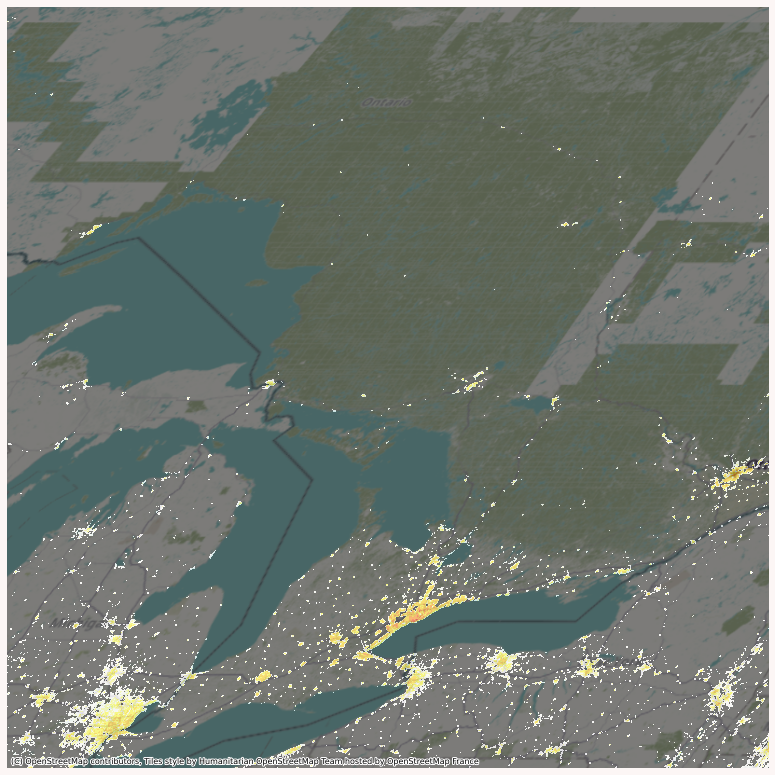

In [13]:
plot_raster(ghs_data_pop_test, raster_pop_test)

## loading shps

In [14]:
from rasterio.plot import plotting_extent

### estimate pop for individual shapes

In [15]:
def compute_pop(row, raster, suffix=""):
    masking_shape = mapping(row["geometry"])
    clipped_array, clipped_transform = msk.mask(raster, shapes=[masking_shape], crop=True)
    clipped_array[0][clipped_array[0] < 0.0] = 0.0  # ensuring zero values are zero
    row["clipped_array"] = clipped_array
    row["clipped_transform"] = clipped_transform
    row["pop".format(suffix)] = clipped_array.sum()
    return row

def compute_pop_from_areas_shp(gdf_bike, raster, suffix="", cropped_to_area = None):
    # cropped_to_area set an additional, previous mask to only contraint to the city limits
    

    # gdf_bike = gdf_bike.set_crs("EPSG:4326")
    # gdf_bike = gdf_bike.to_crs("esri:54009")
     
    if cropped_to_area != None: # i.e. we apply city mask
        area_gdf = query_osm(cropped_to_area) # take city limits from OSM
        # print("AREA CRS:", area_gdf.crs)
        # print("BIKE CRS:", gdf_bike.crs)
        result_gdf = gpd.overlay(area_gdf, gdf_bike, how='intersection')
        gdf_bike = result_gdf # update gdf of bike coverage cropped for the city limits

    shapes = [mapping(geom) for geom in gdf_bike.geometry.tolist()]
    # print(shapes)

    clipped_ghs_data, clipped_transform = msk.mask(raster, shapes=shapes, crop=True)
    
    new_raster_extent = plotting_extent(clipped_ghs_data[0], clipped_transform)
    # clipped_ghs_data, clipped_transform, window = msk.raster_geometry_mask(raster, shapes=shapes, crop=True)
    
    # raster_meta = raster.meta
    # raster.meta = raster.meta.update({"driver": "GTiff",
    #                    "height": clipped_ghs_data.shape[1],
    #                    "width": clipped_ghs_data.shape[2]})
    
#     with rasterio.open("RGB.byte.masked.tif", "w", **raster_meta) as dest:
#         dest.write(clipped_ghs_data) 
        
#     raster = rasterio.open(path)
#     ghs_data = raster.read()

    gdf_bike = gdf_bike.apply(lambda row: compute_pop(row, raster, suffix), axis=1)
    clipped_ghs_data[0][clipped_ghs_data[0] < 0.0] = 0.0  # ensuring zero values are zero
    
    return gdf_bike, clipped_ghs_data, new_raster_extent

def compute_pop_per_individual_geometries(shape_file, raster_pop):
    gdf = gpd.read_file(shape_file)
    gdf = gdf.set_crs("EPSG:4326")
    gdf = gdf.to_crs("esri:54009")
    print("bike shapes shp CRS:", gdf.crs)
    gdf, clipped_array, raster_extent = compute_pop_from_areas_shp(gdf, raster_pop)
    return gdf, clipped_array, raster_extent

### Compute population for merged (unary_union) coverage polygon

In [16]:
def process_shapes_population(location, isochrone_ranges, raster_pop):
    gdf_bike_coverage = gpd.GeoDataFrame(columns=["location", "isochrone_time", "FID", "geometry", "clipped_array", "clipped_transform", "pop"])
    for time in isochrone_ranges:
        # isochrone_shp_file = '../01-data/Bikes/Isochrones/{}/shape_files/union_polygon_{}_min.shp'.format(location, time)
        # isochrone_shp_file = '../01-data/Bikes/Isochrones/{}/shape_files/polygons_{}_min.shp'.format(location, time)
        isochrone_shp_file = '../01-data/Bikes/Isochrones/{}/polygons_{}_min.shp'.format(location, time)
        gdf_bike = gpd.read_file(isochrone_shp_file)
        gdf_bike = gdf_bike.set_crs("EPSG:4326")
        gdf_bike = gdf_bike.to_crs("esri:54009")
        
        # in case that there are separated shapes for each station
        temp_gdf = gdf_bike["geometry"].unary_union
        gdf_bike = gpd.GeoDataFrame(geometry=[temp_gdf], crs=gdf_bike.crs)
        # check for OSM location labels
        if location in dict_cities_names:
            OSM_city_label = dict_cities_names[location]
        else:
            OSM_city_label = location
            
        # cropping the raster for the city limits 
        gdf_bike, clipped_array, raster_extent = compute_pop_from_areas_shp(gdf_bike, raster_pop, suffix="", cropped_to_area = OSM_city_label)
        gdf_bike["location"] = location
        gdf_bike["isochrone_time"] = time
        gdf_bike["raster_extent"] = [raster_extent]
        gdf_bike_coverage = pd.concat([gdf_bike_coverage, gdf_bike], ignore_index=True)
    
    gdf_bike_coverage = gpd.GeoDataFrame(gdf_bike_coverage, geometry="geometry", crs="esri:54009") #crs="EPSG:4326")#
    return gdf_bike_coverage

In [17]:
def plot_range(gdf, raster=None):
    
    fig, ax = plt.subplots(nrows=1, ncols=len(gdf), facecolor='#FCF6F5FF', figsize=(30,10))
    ax = ax.flatten()
    
    for i in gdf.index:
        
        
        # basemap, basemap_extent = cx.bounds2img(*raster.bounds)

        raster_extent=gdf["raster_extent"][i]

        clipped_array=gdf["clipped_array"][i][0]
        # fig.set_size_inches(14, 14)
        ax[i].imshow(clipped_array, norm=norm, cmap=our_cmap, alpha=0.5, extent=raster_extent)
        # ax.imshow(basemap, extent=basemap_extent, zorder=-1)
        ax[i].axis('off')

        cx.add_basemap(ax[i], crs=raster.crs, zorder=-1)
        # plt.show()
        ax[i].set_title("Population covered {} min from station:\n{} inhabitants".format(gdf["isochrone_time"][i], int(gdf["pop"][i])))
    plt.tight_layout()

## using OSM data 
+ (on the fly)
+ Instead of using downloadable shp files, 

In [18]:
import osmnx as ox
# ox.config(use_cache=False, log_console=False)

# def get_area_from_osm(list, type_of_place, raster):
#     query = []
#     for place in list:
#         query.append({type_of_place: place})
#     area_gdf = ox.geocode_to_gdf(query, by_osmid=False).to_crs("esri:54009")
#     # area_gdf = ox.geocode_to_gdf(query, by_osmid=False).to_crs("EPSG:4326")

#     shapes = [mapping(geom) for geom in area_gdf.geometry.tolist()]
#     clipped_array, clipped_transform = msk.mask(raster, shapes=shapes, crop=True)
    
#     return clipped_array, clipped_transform

def query_osm(query):
    area_gdf = ox.geocode_to_gdf(query).to_crs("esri:54009")
    
    # print("CRS from query_osm", area_gdf.crs)

    # in case there are several areas, merged geometries
    if isinstance(query, list) and len(query)>1:
        merged_geometry = area_gdf.unary_union
        # Create a new GeoDataFrame with the merged geometry
        area_gdf = gpd.GeoDataFrame(geometry=[merged_geometry], crs=area_gdf.crs)
    
    # print("CRS from query_osm", area_gdf.crs)
    
    return area_gdf

def get_area_from_osm(query, type_of_place, raster):

    area_gdf = query_osm(query)#.to_crs("EPSG:4326")
    
    area = area_gdf["geometry"].area / 10**6
    # print(area)
    # area_gdf = ox.geocode_to_gdf(query, by_osmid=False).to_crs("EPSG:4326")
    

    shapes = [mapping(geom) for geom in area_gdf.geometry.tolist()]
    clipped_array, clipped_transform = msk.mask(raster, shapes=shapes, crop=True)
    
    return clipped_array, clipped_transform, area


def plot_cropped_raster(clipped_array):
    fig, ax = plt.subplots(facecolor='#FCF6F5FF')
    fig.set_size_inches(14, 7)
    ax.imshow(clipped_array[0], norm=norm, cmap=our_cmap, alpha=0.5)
    ax.axis('off')
    # cx.add_basemap(ax, crs=raster_pop_test.crs, zorder=-1)
    plt.show()

    
def plot_range(gdf, raster=None):
    
    fig, ax = plt.subplots(nrows=1, ncols=len(gdf), facecolor='#FCF6F5FF', figsize=(30,10))
    ax = ax.flatten()
    
    for i in gdf.index:
        
        
        # basemap, basemap_extent = cx.bounds2img(*raster.bounds)

        raster_extent=gdf["raster_extent"][i]

        clipped_array=gdf["clipped_array"][i][0]
        # fig.set_size_inches(14, 14)
        ax[i].imshow(clipped_array, norm=norm, cmap=our_cmap, alpha=0.5, extent=raster_extent)
        # ax.imshow(basemap, extent=basemap_extent, zorder=-1)
        ax[i].axis('off')

        cx.add_basemap(ax[i], crs=raster.crs, zorder=-1)
        # plt.show()
        ax[i].set_title("Population covered {} min from station:\n{} inhabitants".format(gdf["isochrone_time"][i], int(gdf["pop"][i])))
    plt.tight_layout()

#### test

,location,isochrone_time,FID,geometry,clipped_array,clipped_transform,pop,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,raster_extent
0,Toronto,5,NaN,"MULTIPOLYGON (((-6494725.047 5197475.546, -649...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -6514100.0, 0.0, -100.0, 5202600....",514299.7545596564,43.7360196000,43.6103840000,-79.2785104000,-79.4928210000,304153518.0000000000,relation,2989349.0000000000,43.6534817000,-79.3839347000,boundary,administrative,16.0000000000,0.7130149417,city,Old Toronto,"Old Toronto, Toronto, Golden Horseshoe, Ontari...","(-6514100.0, -6494500.0, 5190800.0, 5202600.0)"
1,Toronto,10,NaN,"MULTIPOLYGON (((-6514341.819 5192767.843, -651...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -6514400.0, 0.0, -100.0, 5202600....",751816.2465062048,43.7360196000,43.6103840000,-79.2785104000,-79.4928210000,304153518.0000000000,relation,2989349.0000000000,43.6534817000,-79.3839347000,boundary,administrative,16.0000000000,0.7130149417,city,Old Toronto,"Old Toronto, Toronto, Golden Horseshoe, Ontari...","(-6514400.0, -6494500.0, 5190600.0, 5202600.0)"
2,Toronto,15,NaN,"MULTIPOLYGON (((-6514356.877 5192602.068, -651...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -6514500.0, 0.0, -100.0, 5202600....",787534.0376062784,43.7360196000,43.6103840000,-79.2785104000,-79.4928210000,304153518.0000000000,relation,2989349.0000000000,43.6534817000,-79.3839347000,boundary,administrative,16.0000000000,0.7130149417,city,Old Toronto,"Old Toronto, Toronto, Golden Horseshoe, Ontari...","(-6514500.0, -6494500.0, 5190600.0, 5202600.0)"


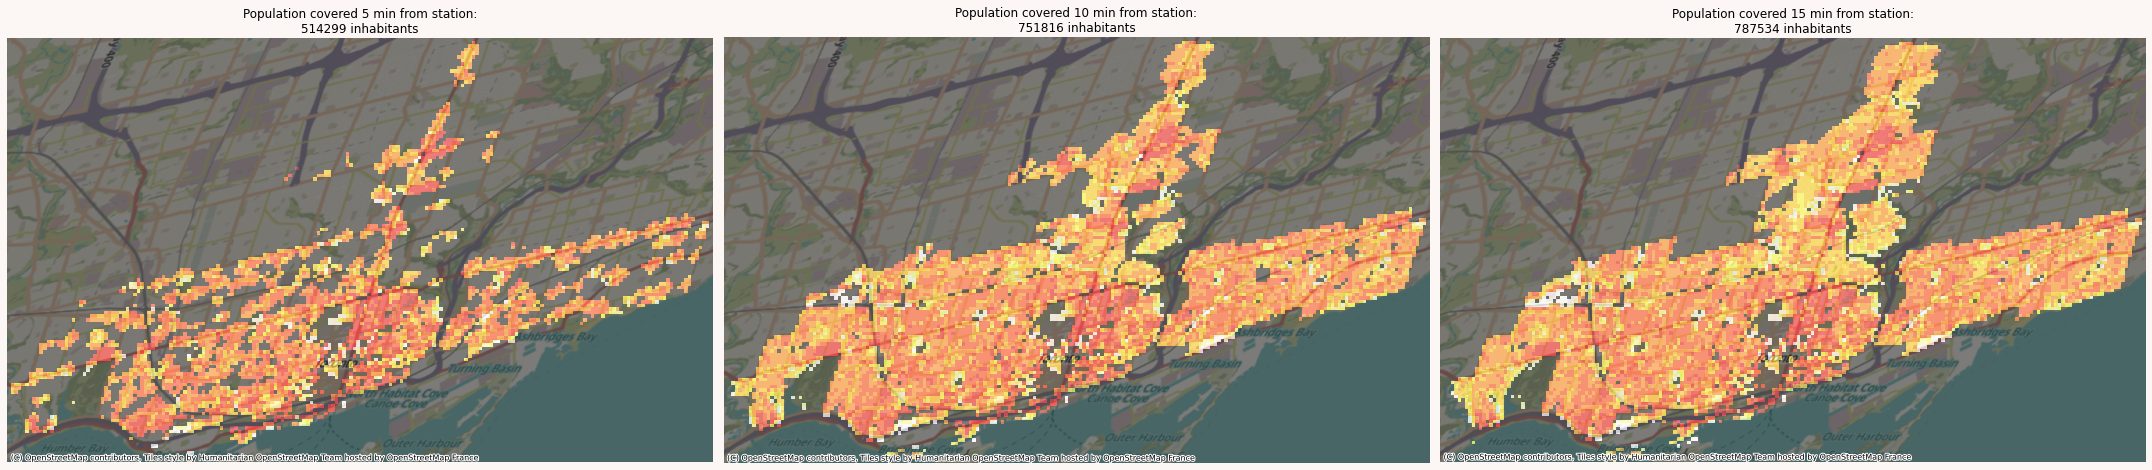

In [22]:
isochrone_ranges = [5, 10, 15]
location = "Toronto"
raster_pop_test, _ = open_raster(dict_cities_tiles_100mMollveide[location])
gdf_test_bikes = process_shapes_population(location, isochrone_ranges, raster_pop_test)
display(gdf_test_bikes)
plot_range(gdf_test_bikes, raster=raster_pop_test)

# TO DO Adding city limits line

#### test

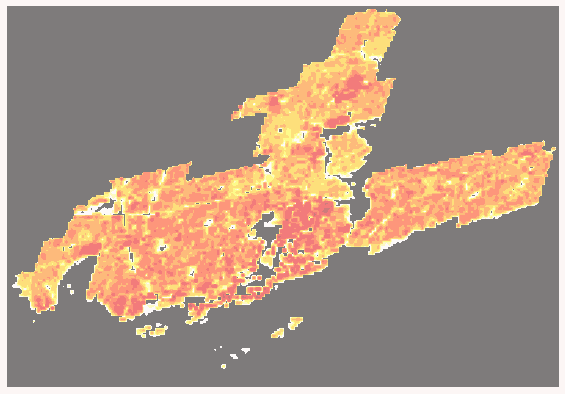

In [20]:
# interest_areas = ["Madrid", "Las Rozas de Madrid", "Valdemoro", "Boadilla del Monte", "Navalcarnero"]
interest_areas = "Toronto"
raster_pop_test, _ = open_raster(dict_cities_tiles_100mMollveide[location])
clipped_array, clipped_transform, area = get_area_from_osm(interest_areas, "city", raster_pop_test)
plot_cropped_raster(clipped_array)

#TO DO: adding background

# Process data
Create gedataframe with a row for each city time isochrone (5, 10, 15).
Columns:

location | isochrone_time | FID | geometry | clipped_array | clipped_transform | pop | raster_extent

In [23]:
def get_raster_data_for_city(city):
    print(city)
    # download raster from internet
    url_raster_for_city = dict_cities_tiles_100mMollveide[city]
    # 1st check if it has been downloaded and processed:
    if url_raster_for_city in dict_rasters:
        raster_pop_test, ghs_data_pop_test = dict_rasters[url_raster_for_city]
    else: # if it has not been downloaded, downlaod
        raster_pop_test, ghs_data_pop_test = open_raster(url_raster_for_city)
        # and save it in the dictionary
        dict_rasters[url_raster_for_city] = raster_pop_test, ghs_data_pop_test
    return raster_pop_test, ghs_data_pop_test

def compute_bike_coverage_for_city(raster_pop_test, ghs_data_pop_test, city):
    # create GDF for city
    isochrone_ranges = [5, 10, 15]
    gdf_bike_coverage_city = process_shapes_population(city, isochrone_ranges, raster_pop_test)  
    return gdf_bike_coverage_city


def compute_city_data(raster_pop_test, ghs_data_pop_test, city):
    df_city_data = pd.DataFrame(columns=["location", "total_pop", "area", "populated_area", "clipped_array"])
    print(city)
    # check in the diccionary of equivalent names, if the city name needs to be adjusted for OSM
    if city in dict_cities_names:
        location = dict_cities_names[city]
    else:
        location = city
    # cropping the raster for the city limits
    clipped_array, clipped_transform, area = get_area_from_osm(location, "city", raster_pop_test)
    
    clipped_array[0][clipped_array[0] < 0.0] = 0.0  # ensuring zero values are zero
    
    # populate dataframe
    df_city_data = pd.DataFrame({"location":city, 
                                 "total_pop": clipped_array.sum(), 
                                 "area": area, 
                                 "populated_area": np.sum(clipped_array>0)*0.01, # count values greater than 0. Each cell is 100 x 100 m = 0.01 km^2. So to get km^2, multiply by 0.01 
                                 "clipped_array": [clipped_array]})

    # print(df_city_data)
    return df_city_data




# create new dictionary for storing the downloaded raster (avoid multiple downloads). Processing only the first time it is downloaded
dict_rasters = dict()
dict_city_pops = dict()
dict_city_area = dict()
dict_city_populated_area = dict()

# creare empty geodataframe for bikes coverage
gdf_bike_coverages = gpd.GeoDataFrame(columns=["location", "isochrone_time", "FID", "geometry", "clipped_array", "clipped_transform", "pop"])

# creare empty geodataframe for cities
gdf_cities_data = gpd.GeoDataFrame(columns=["location", "total_pop", "area", "populated_area", "clipped_array"])

# iterate through the cities in a dictionary
for city in dict_cities_tiles_100mMollveide:
    # preprocess raster
    raster_pop_test, ghs_data_pop_test = get_raster_data_for_city(city)
    
    ## BIKES
    # compute data for bike coverage per city
    gdf_bike_coverage_city = compute_bike_coverage_for_city(raster_pop_test, ghs_data_pop_test, city)
    # add to the main gdf for bikes and consolitate
    gdf_bike_coverages = pd.concat([gdf_bike_coverages, gdf_bike_coverage_city], ignore_index=True)
    
    ## CITY DATA
    # get city data
    gdf_city_data = compute_city_data(raster_pop_test, ghs_data_pop_test, city)
    # add to the main gdf for city data
    gdf_cities_data = pd.concat([gdf_cities_data, gdf_city_data], ignore_index=True)

gdf_bike_coverages = gdf_bike_coverages[["location", "isochrone_time", "FID", "geometry", "clipped_array", "clipped_transform", "pop"]]

Almaty
Almaty
Austin
Austin
Bergen
Bergen
Bern
Bern
Bogota
Bogota
Dortmund
Dortmund
Exeter
Exeter
Gent
Gent
Glasgow
Glasgow
Guadalajara
Guadalajara
Hamilton
Hamilton
Hiroshima
Hiroshima
Innsbruck
Innsbruck
LA
LA
Lausanne
Lausanne
Lisbon
Lisbon
London
London
Lugano
Lugano
Luzern
Luzern
MXC
MXC
Madrid
Madrid
Manhattan
Manhattan
Marseille
Marseille
Milan
Milan
Montreal
Montreal
Naha, Okinawa
Naha, Okinawa
Nice
Nice
Osaka
Osaka
Oslo
Oslo
Philadelphia
Philadelphia
Portland
Portland
Riga
Riga
Rio
Rio
Rosario
Rosario
San Antonio
San Antonio
Taipei
Taipei
Toronto
Toronto
Turku
Turku
Washington
Washington
Zurich
Zurich


In [24]:
gdf_bike_coverages

,location,isochrone_time,FID,geometry,clipped_array,clipped_transform,pop
0,Almaty,5,NaN,"MULTIPOLYGON (((6327670.358 5148913.319, 63277...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 6320300.0, 0.0, -100.0, 5151800.0...",326909.6118626278
1,Almaty,10,NaN,"MULTIPOLYGON (((6325098.592 5145332.425, 63250...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 6319900.0, 0.0, -100.0, 5152100.0...",733873.1920331963
2,Almaty,15,NaN,"POLYGON ((6324190.733 5145399.066, 6324117.444...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 6319600.0, 0.0, -100.0, 5152400.0...",862334.6364751072
3,Austin,5,NaN,"MULTIPOLYGON (((-8942739.033 3673166.737, -894...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -8949400.0, 0.0, -100.0, 3678700....",42926.3678044304
4,Austin,10,NaN,"MULTIPOLYGON (((-8948245.282 3673060.552, -894...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -8949700.0, 0.0, -100.0, 3678800....",81851.3113300854
...,...,...,...,...,...,...,...
115,Washington,10,NaN,"MULTIPOLYGON (((-6597084.811 4665441.884, -659...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -6612200.0, 0.0, -100.0, 4675300....",583132.1586369878
116,Washington,15,NaN,"POLYGON ((-6610728.825 4669719.451, -6610356.2...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -6612200.0, 0.0, -100.0, 4675600....",675104.3593924178
117,Zurich,5,NaN,"MULTIPOLYGON (((675431.184 5598213.801, 675407...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 666000.0, 0.0, -100.0, 5601200.0,...",196854.9585232958
118,Zurich,10,NaN,"MULTIPOLYGON (((675431.184 5598213.801, 675407...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 665700.0, 0.0, -100.0, 5601400.0,...",317033.6580366883


In [31]:
# normalize for total pop

def normalize_pop_served(row):
    city = row["location"]
    total_pop = gdf_cities_data[gdf_cities_data["location"]==city]["total_pop"].values[0]
    row["served_pop_over_total"] = row["pop"] / total_pop
    # print(row["pop"])
    # print(total_pop)
    return row
    
gdf_bike_coverages = gdf_bike_coverages.apply(lambda row: normalize_pop_served(row), axis=1)

In [32]:
# normalize for area covered by bikes based on total surface

# compute area of bikes coverage
# gdf_bike_coverages["area_coverage_bikes"] = gdf_bike_coverages["geometry"].area / 10**6 # using geometry directy does not work because it is not cropped with the city limits
def compute_area_coverage_bikes(row):
    clipped_array = row["clipped_array"][0]
    row["area_coverage_bikes"] = np.sum(clipped_array>0)*0.01 # count values greater than 0. Each cell is 100 x 100 m = 0.01 km^2. So to get km^2, multiply by 0.01
    return row

gdf_bike_coverages = gdf_bike_coverages.apply(lambda row: compute_area_coverage_bikes(row), axis=1)

In [33]:
# normalize based on total city limits area
def normalize_area_served(row):
    city = row["location"]
    total_area = gdf_cities_data[gdf_cities_data["location"]==city]["area"].values[0]
    row["served_area_over_total"] = row["area_coverage_bikes"] / total_area
    # print(row["pop"])
    # print(total_pop)
    return row
    
gdf_bike_coverages = gdf_bike_coverages.apply(lambda row: normalize_area_served(row), axis=1)

In [34]:
# normalize for area covered by bikes based on total surface effectively populated

# normalize based on total city limits area effectively populated
def normalize_area_served(row):
    city = row["location"]
    total_area = gdf_cities_data[gdf_cities_data["location"]==city]["populated_area"].values[0]
    row["served_area_over_total_area_populated"] = row["area_coverage_bikes"] / total_area
    # print(row["pop"])
    # print(total_pop)
    return row
    
gdf_bike_coverages = gdf_bike_coverages.apply(lambda row: normalize_area_served(row), axis=1)

In [35]:
gdf_bike_coverages

,location,isochrone_time,FID,geometry,clipped_array,clipped_transform,pop,served_pop_over_total,area_coverage_bikes,served_area_over_total,served_area_over_total_area_populated
0,Almaty,5,NaN,"MULTIPOLYGON (((6327670.358 5148913.319, 63277...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 6320300.0, 0.0, -100.0, 5151800.0...",326909.6118626278,0.1518269635,23.6500000000,0.0335399861,0.0644624945
1,Almaty,10,NaN,"MULTIPOLYGON (((6325098.592 5145332.425, 63250...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 6319900.0, 0.0, -100.0, 5152100.0...",733873.1920331963,0.3408334730,57.6200000000,0.0817156025,0.1570540776
2,Almaty,15,NaN,"POLYGON ((6324190.733 5145399.066, 6324117.444...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 6319600.0, 0.0, -100.0, 5152400.0...",862334.6364751072,0.4004949523,73.9800000000,0.1049170475,0.2016463149
3,Austin,5,NaN,"MULTIPOLYGON (((-8942739.033 3673166.737, -894...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -8949400.0, 0.0, -100.0, 3678700....",42926.3678044304,0.0367231835,5.3800000000,0.0073977667,0.0118784774
4,Austin,10,NaN,"MULTIPOLYGON (((-8948245.282 3673060.552, -894...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -8949700.0, 0.0, -100.0, 3678800....",81851.3113300854,0.0700231788,13.8600000000,0.0190581871,0.0306014307
...,...,...,...,...,...,...,...,...,...,...,...
115,Washington,10,NaN,"MULTIPOLYGON (((-6597084.811 4665441.884, -659...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -6612200.0, 0.0, -100.0, 4675300....",583132.1586369878,0.8130580751,73.6500000000,0.4150010792,0.6639322095
116,Washington,15,NaN,"POLYGON ((-6610728.825 4669719.451, -6610356.2...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, -6612200.0, 0.0, -100.0, 4675600....",675104.3593924178,0.9412944267,95.7100000000,0.5393041858,0.8627963581
117,Zurich,5,NaN,"MULTIPOLYGON (((675431.184 5598213.801, 675407...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 666000.0, 0.0, -100.0, 5601200.0,...",196854.9585232958,0.4924137348,20.0800000000,0.2186842530,0.3178724078
118,Zurich,10,NaN,"MULTIPOLYGON (((675431.184 5598213.801, 675407...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(100.0, 0.0, 665700.0, 0.0, -100.0, 5601400.0,...",317033.6580366883,0.7930291865,37.4900000000,0.4082904703,0.5934779167


In [36]:
gdf_cities_data

,location,total_pop,area,populated_area,clipped_array
0,Almaty,2153172.2973769559,705.1284971163,366.8800000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,Austin,1168917.3897835228,727.2465063883,452.9200000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,Bergen,290886.5434395997,568.2522204602,148.5800000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,Bern,123805.2577156406,51.5929642975,29.6900000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,Bogota,9146543.3699750509,1641.9253449685,441.8000000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
5,Dortmund,608738.5087863719,280.4032714652,199.1200000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,Exeter,122290.9247641338,47.8424931674,36.5100000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,Gent,260277.4576769304,157.5059813025,123.5800000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,Glasgow,613950.7380896448,175.9628819048,145.3600000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,Guadalajara,1363703.7635982167,152.0231620902,142.1600000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


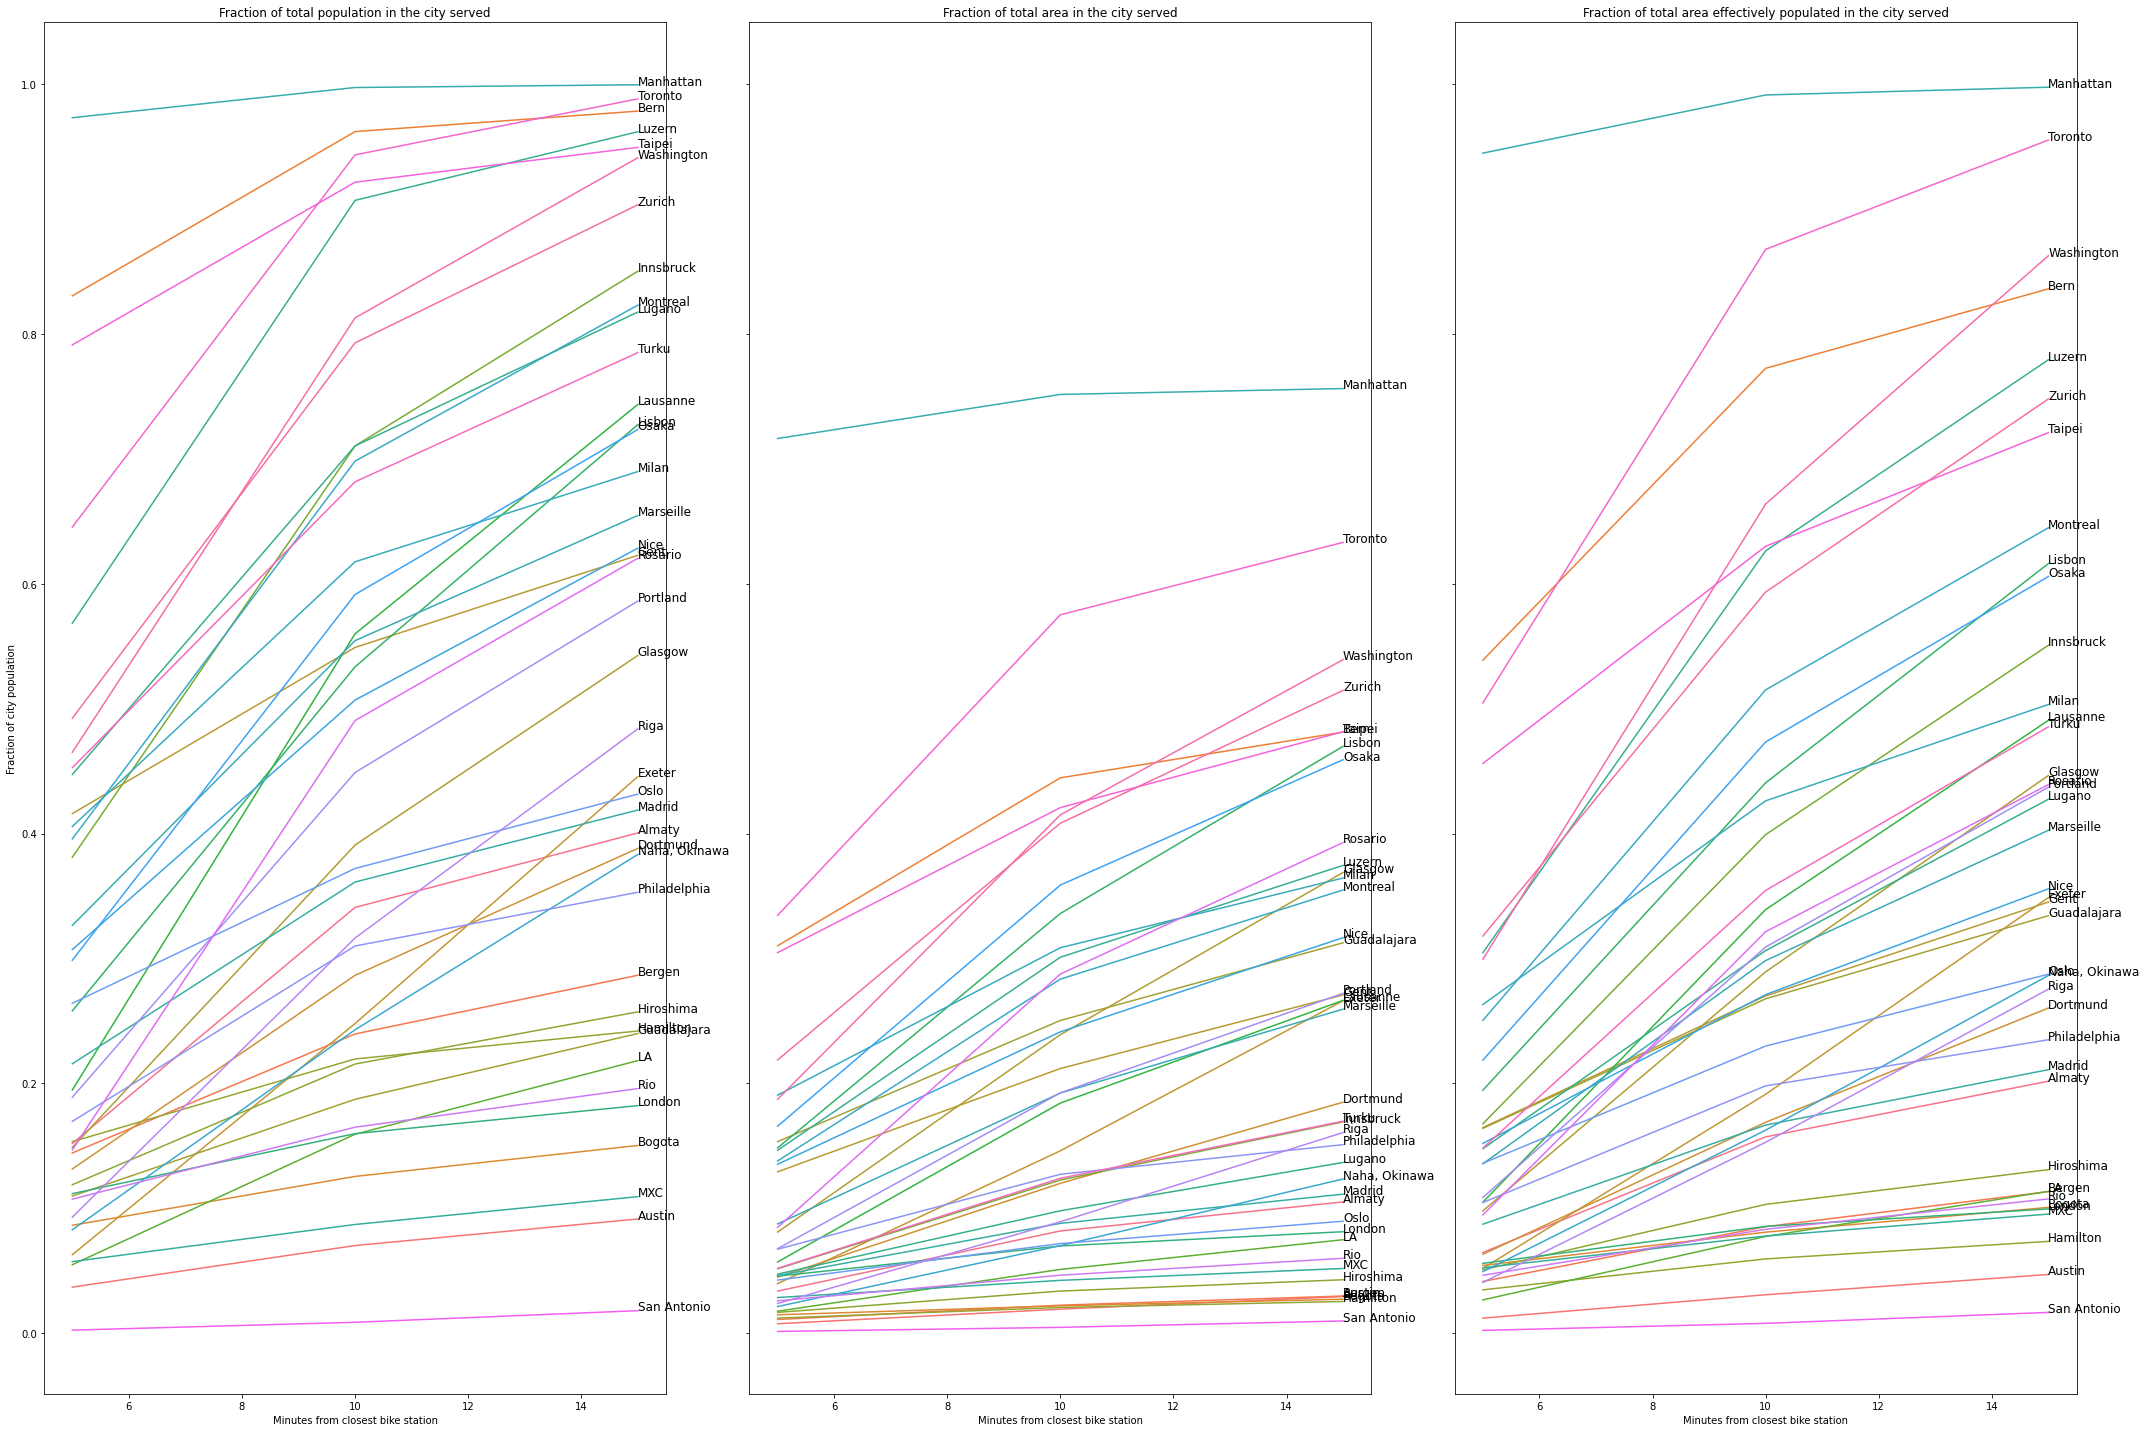

In [37]:
import matplotlib.pyplot as plt

# Create a line plot with Seaborn
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 20), sharey=True)  # Optional: Set the figure size
axs = axs.flatten()

# plot 0
g0 = sns.lineplot(ax=axs[0], data=gdf_bike_coverages, x="isochrone_time", y="served_pop_over_total", hue="location")
# plt.legend(bbox_to_anchor=(1.02, 0.55), loc='bottom center', borderaxespad=0)
g0.legend_.remove()

# Iterate through unique locations and add labels to the lines
for location, group in gdf_bike_coverages.groupby('location'):
    last_point = group.iloc[-1]
    axs[0].text(last_point['isochrone_time'], last_point['served_pop_over_total'], location, fontsize=12, color='black')

# Customize the plot
axs[0].title.set_text("Fraction of total population in the city served")
axs[0].set_xlabel("Minutes from closest bike station")
axs[0].set_ylabel("Fraction of city population")

# plot 1
g1 = sns.lineplot(ax=axs[1], data=gdf_bike_coverages, x="isochrone_time", y="served_area_over_total", hue="location")
g1.legend_.remove()

# Iterate through unique locations and add labels to the lines
for location, group in gdf_bike_coverages.groupby('location'):
    last_point = group.iloc[-1]
    axs[1].text(last_point['isochrone_time'], last_point['served_area_over_total'], location, fontsize=12, color='black')

# Customize the plot
axs[1].title.set_text("Fraction of total area in the city served")
axs[1].set_xlabel("Minutes from closest bike station")
axs[1].set_ylabel("Fraction of city area")

# plot 2
g2 = sns.lineplot(ax=axs[2], data=gdf_bike_coverages, x="isochrone_time", y="served_area_over_total_area_populated", hue="location")
g2.legend_.remove()

# Iterate through unique locations and add labels to the lines
for location, group in gdf_bike_coverages.groupby('location'):
    last_point = group.iloc[-1]
    axs[2].text(last_point['isochrone_time'], last_point['served_area_over_total_area_populated'], location, fontsize=12, color='black')

# Customize the plot
axs[2].title.set_text("Fraction of total area effectively populated in the city served")
axs[2].set_xlabel("Minutes from closest bike station")
axs[2].set_ylabel("Fraction of city area effectively populated")



# Adjust the layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

In [40]:
gdf_bike_coverages.crs

<Derived Projected CRS: ESRI:54009>
Name: World_Mollweide
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World_Mollweide
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
### save gdf
gdf_bike_coverages.to_pickle("../01-data/Bikes/processed/gdf_bikes_coverage_crs_esri_54009.pkl")
gdf_cities_data.to_pickle("../01-data/Bikes/processed/df_cities_data.pkl")